<a href="https://colab.research.google.com/github/LeeSeungwon89/Deep-learning_Theory/blob/main/9-2%20%EC%88%9C%ED%99%98%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9C%BC%EB%A1%9C%20IMDB%20%EB%A6%AC%EB%B7%B0%20%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **9-2 순환 신경망으로 IMDB 리뷰 분류하기**

IMDB 리뷰 데이터 세트로 간단한 순환 신경망 모델을 훈련해 보겠습니다. 이 데이터 세트를 두 가지 방법(원-핫 인코딩, 단어 임베딩)으로 변형하여 순환 신경망에 주입해 보겠습니다.

## **IMDB 리뷰 데이터셋**

IMDB 리뷰 데이터 세트는 인터넷 영화 데이터베이스인 imdb.com 사이트에서 수집한 리뷰를 긍정과 부정으로 분류한 데이터 세트입니다. 샘플 50,000개로 구성되며 훈련 데이터와 테스트 데이터는 25,000개씩 구성됩니다.

**자연어 처리(natural language processing, NLP)**는 컴퓨터를 사용하여 인간의 언어(자연어)를 처리하는 분야입니다. 대표되는 세부 분야는 음성 인식, 기계 번역, 감성 분석 등입니다. 이 챕터에서 다룰 데이터 세트로는 감성 분석을 수행합니다. 자연어 처리 분야에서는 훈련 데이터를 **말뭉치(corpus)**라고 부르기도 합니다.

기실 텍스트 자체를 신경망에 전달하는 것이 아닙니다. 컴퓨터는 숫자 데이터만 처리할 수 있습니다. 합성곱 신경망에서 이미지를 다룰 때 이미지는 이미 픽셀값(정수)으로 구성되므로 숫자로 변환하는 작업이 필요하지 않습니다. 그러나 텍스트 데이터는 단어를 정수 데이터로 변환하는 작업이 필요합니다. 아래와 같은 문장이 있다고 가정하겠습니다.

He follows the cat. He loves the cat.

이 문장의 단어인 He, follows, the, cat. 등에 고유한 정수를 부여(매핑)합니다. 같은 단어에는 같은 정수를 부여합니다. 정수 사이에는 어떠한 관계도 없이 고유할 뿐입니다. 일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제하여 공백 기준으로 분리합니다. 이렇게 분리된 단어를 **토큰(token)**이라고 부릅니다. 샘플 하나는 여러 토큰으로 구성되며, 토큰 1개는 타임스템프 하나입니다. 간단한 문제라면 영어 말뭉치에서 토큰을 단어와 같다고 볼 수 있습니다. 토큰에 할당하는 정수 중에 몇 개는 특정 용도로 예약되어 있습니다. 예컨대 0은 패딩, 1은 문장 시작, 2는 어휘 사전(훈련 데이터 세트에서 고유한 단어를 뽑아 생성한 목록)에 존재하지 않는 토큰을 의미합니다. 테스트 데이터 세트에 어휘 사전에 존재하지 않는 단어가 있다면 2로 변환하여 신경망 모델에 주입합니다. 

참고로 한국어는 영어와 전혀 다릅니다. 한국어는 조사가 발달된 언어이므로 공백으로만 나눠서는 문장 의미를 제대로 분석하기 어렵습니다. 한국어에 대한 자연어 처리는 `KoNLPy`를 사용합니다.

IMDB 리뷰 데이터 세트는 영어로 된 문장입니다. 텐서플로에 이 데이터 세트를 정수로 바꾼 데이터가 포함되어 있으므로 굳이 정수로 바꾸는 작업은 필요하지 않습니다. 데이터를 준비하겠습니다.

In [2]:
from tensorflow.keras.datasets import imdb

# 가장 자주 등장하는 단어 500개만 사용하기 위해 `num_words=500`으로 지정합니다.
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
print(train_input.shape, test_input.shape)

17473536/17464789 [==============================] - 0s 0us/step
(25000,) (25000,)


처음 데이터만 확인해 보겠습니다.

In [3]:
print(train_input)

[list([1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32])
 list([1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 2, 8, 118, 2, 14, 394, 20, 13, 119, 2, 189, 102, 5, 207, 110, 2, 21, 14, 69, 188, 

리뷰 텍스트는 길이가 모두 다르므로 2차원 배열에 담지 않고 리뷰마다 별도로 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있습니다. 따라서 리스트 안에 리스트(리뷰 하나) 객체가 여러 개 나열된 형태이며 1차원 넘파이 배열입니다.

리뷰 몇 개만 길이를 확인해 보겠습니다.

In [4]:
print(len(train_input[0]))
print(len(train_input[1]))
print(len(train_input[2]))

218
189
141


각각 토큰 218개, 189개, 141개로 구성된 리뷰입니다. 리뷰 하나는 샘플 하나입니다.

첫 번째 리뷰 내용만 확인해 보겠습니다.

In [5]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


정수로 변환된 리뷰입니다. 위에서 `num_words=500`으로 지정했으므로 어휘 사전에는 단어가 500개만 구성된 상태이며, 어휘 사전에 없는 단어는 2로 대체됐습니다.

타깃 데이터를 확인해 보겠습니다.

In [6]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


부정은 0, 긍정은 1이며 이진 분류 문제입니다.

훈련 데이터 세트에서 검증 데이터 세트를 만들겠습니다.

In [7]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

리뷰의 평균 길이와 중간 길이, 최소 및 최대 길이를 확인해 보겠습니다.

In [8]:
import numpy as np

lengths = np.array([len(x) for x in train_input])
# 평균 및 중간값을 구합니다.
print(np.mean(lengths), np.median(lengths))
# 최솟값 및 최댓값을 구합니다.
print(min(lengths), max(lengths))

239.00925 178.0
11 1854


리뷰 길이 개수를 히스토그램으로 시각화해 보겠습니다.

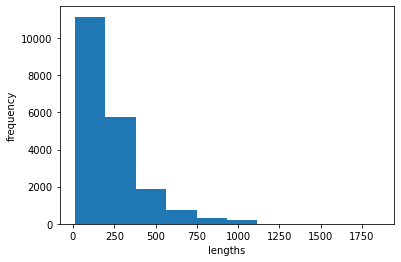

In [9]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('lengths')
plt.ylabel('frequency')
plt.show()

리뷰 대부분은 300미만의 길이를 가집니다. 평균이 중간값보다 높은 이유는 최댓값이 매우 크기 때문입니다.

리뷰 대부분 길이가 짧으므로 단어를 100개만 사용하겠습니다. 그러나 단어가 100개 미만으로 구성된 리뷰도 있으므로 리뷰 길이를 100에 맞추기 위해 패딩을 수행해야 합니다. 위에서 서술했듯이 패딩을 나타내는 토큰은 0을 사용합니다.

물론 수동으로 훈련 데이터 세트에 있는 리뷰 20,000개를 순회하면서 길이가 100이 되도록 자르거나 0으로 패딩 할 수 있지만 `pad_sequences()` 메서드를 사용하면 시퀀스 데이터 길이를 맞출 수 있습니다. `train_input`의 길이를 100으로 맞춰 보겠습니다.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# `maxlen` 매개변수에 100으로 지정하면 긴 경우는 잘라내고 짧은 경우는 0으로 패딩합니다.
train_seq = pad_sequences(train_input, maxlen=100)
print(train_seq)
print(train_seq.shape)

[[ 10   4  20 ...  10 470 158]
 [206   2  26 ...   6   2   2]
 [  2   7   2 ...   2   2  12]
 ...
 [  2  37 299 ...   7  14   2]
 [  0   0   0 ...  25 170   2]
 [  0   0   0 ...  25 194   2]]
(20000, 100)


`train_input`은 리스트 내에 리스트 객체가 구성된 1차원 배열 (20000,)이지만, `train_seq`는 리스트 내에 리스트가 구성된 2차원 배열 (20000, 100)입니다. 샘플 20,000개, 토큰(타임스텝) 개수 100개입니다.

첫 번째 샘플만 확인해 보겠습니다.

In [11]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


이 샘플 길이는 100보다 길었기 때문에 샘플 원소로 0이 없습니다. 

원본과 비교하여 앞과 뒤 중에 어떤 부분이 잘렸는지 확인해 보겠습니다.

In [12]:
# 맨 앞 원소를 10개만 확인합니다.
print(train_input[0][:10])

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141]


In [13]:
# 맨 뒤 원소를 10개만 확인합니다.
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


`train_input[0]`과 `train_seq[0]`의 앞부분 원소는 불일치하지만 뒷부분 원소는 일치합니다. 앞부분이 잘렸다고 판단할 수 있습니다. 즉 `pad_sequences()` 메서드는 매개변수 `maxlen`에 지정한 값보다 긴 시퀀스의 앞부분을 자릅니다. 앞부분을 자르는 이유는 시퀀스의 뒷부분이 가진 정보가 더 유용할 것이라고 예상하기 때문입니다. 특히 이 리뷰 데이터 세트의 경우 리뷰의 앞부분보다는 뒷부분에 더 결정적이고 중요한 소감을 말할 가능성이 높습니다. 만약 뒷부분을 자르려면 매개변수 `truncating`의 디폴트인 `pre`가 아닌 `post`를 지정합니다.

이번에는 `train_seq`의 여섯 번째 샘플을 확인해 보겠습니다.

In [14]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


앞부분 원소 4개가 0입니다. 여섯 번째 샘플 길이는 96입니다. 시퀀스의 앞부분을 자르는 것과 같은 이치로써 패딩 토큰 또한 시퀀스의 뒷부분이 아닌 앞부분에 추가됩니다. 시퀀스의 마지막에 구성된 단어가 셀의 은닉 상태에 가장 큰 영향을 미칠 가능성이 높으므로 뒷부분에 패딩을 추가하는 것은 선호되는 방법이 아닙니다. 만약 패딩을 뒷부분에 추가하려면 매개변수 `padding`의 디폴트인 `pre`를 `post`로 지정합니다.

검증 데이터 세트의 길이도 100으로 지정하겠습니다.

In [16]:
val_seq = pad_sequences(val_input, maxlen=100)
print(val_seq)
print(val_seq.shape)

[[ 32   2 225 ...  14  58   2]
 [ 53   2   8 ...   7  32   2]
 [  0   0   0 ...   2  33  32]
 ...
 [383   2 120 ...  16  99  76]
 [106 345  12 ... 120   2 156]
 [  4 114  21 ...   4   2   2]]
(5000, 100)


## **순환 신경망 만들기**



---

작업 중

---



## **순환 신경망 훈련하기**

## **단어 임베딩을 사용하기**